# Demonstration of warmstart grid search to compare classifier performance

An important step in classifier performance comparison is hyperparameter 
optimization. Here, we specify the classifer models we want to tune and a 
dictionary of hyperparameter ranges (preferably similar for fairness in 
comparision) for each classifier. Then, we find the optimal hyperparameters 
through a function that implements warmstart grid search and refit the optimized 
models to obtain accuracies. The performance of each hyperparameter value pairing is visualized in heatmaps.

In this example, we tune hyperparameters for two classifiers, Random Forest and Extra Trees, and compare their performance on an OpenML-CC18 benchmarking suite dataset (https://www.openml.org/d/15).  We can see clearly in the resulting plot that the optimized models perform better than or atleast similar to the default parameter models. On the dataset we use in this example, RF performs marginally better than ExtraTrees overall.


In [1]:
print(__doc__)

import pandas as pd
import numpy as np
import time

import sklearn
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml

import matplotlib
import matplotlib.pyplot as plt

from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

Automatically created module for IPython interactive environment


In [2]:
def warmstart_gridsearch(X, y, clf, params, scorer):
    """
    Given a classifier and two hyperparameters and the 
    range/values to search for each, find optimal hyperparameter 
    values using warmstart grid search parameter sweeps.

    Parameters
    ----------
    X : numpy.ndarray
        Input data, shape (n_samples, n_features)
    y : numpy.ndarray
        Output data, shape (n_samples, n_outputs)
    clf : sklearn-compliant classifier
            For example sklearn.ensemble.RandomForestRegressor
    params : dictionary of hyperparameter values or range

    Returns
    -------
    best_params : dictionary
        Dictionary of best hyperparameters
    """
    param1_name = list(params.keys())[0]
    param2_name = list(params.keys())[1]
    param1 = params[param1_name]
    param2 = params[param2_name]

    # sweep over all pairs of parameter combinations and collect mean scores
    mean_scores = np.zeros((np.shape(param1)[0], np.shape(param2)[0]))
    for idx1, val1 in enumerate(param1):
        clf.max_features = val1 #change .max_features to .name of 1st parameter
        for idx2, val2 in enumerate(param2):
            clf.n_estimators = val2 #change .n_estimators to .name of 2nd parameter 
            score = cross_val_score(clf, X, y, scoring=scorer, cv=5)
            mean_scores[idx1][idx2] = np.mean(score)

    # select parameter pair with highest kappa score
    best_idx1, best_idx2 = np.unravel_index(
        np.argmax(mean_scores, axis=None), np.shape(mean_scores)
    )
    best_params = {param1_name: param1[best_idx1], param2_name: param2[best_idx2]}

    return best_params

# Building classifiers and specifying parameter ranges or values to search


In [3]:
# get some data
X, y = fetch_openml(data_id=40979, return_X_y=True, as_frame=True)
y = pd.factorize(y)[0]
X = X.apply(lambda x: pd.factorize(x)[0])
n_samples, n_features = np.shape(X)

# build a classifier with warm_start=True
rf = RandomForestClassifier(warm_start=True)

param_dicts = []
# specify parameters and ranges or values to search
param_dicts.append({
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [10, 30, 50, 70],
})

param_dicts.append({
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [50, 100, 150, 200],
})

param_dicts.append({
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [100, 150, 200, 250],
})

# Obtaining best parameters dictionary and refitting

In [4]:
kappa_scorer = make_scorer(cohen_kappa_score)

warm_runtimes = []
for i in range(3):
    
    start_time = time.time()
    tuned_params = warmstart_gridsearch(
        X, y, rf, param_dicts[i], kappa_scorer
    )
    print("--- %s seconds ---" % (time.time() - start_time))
    print(tuned_params)
    runtime = time.time() - start_time

    # extract values from dict - seperate each classifier's param dict
    keys, values = zip(*tuned_params.items())

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42
    )
    warm_runtimes.append(runtime)

--- 37.36357617378235 seconds ---
{'max_features': 'sqrt', 'n_estimators': 70}
--- 113.85778212547302 seconds ---
{'max_features': 'sqrt', 'n_estimators': 100}
--- 162.4899411201477 seconds ---
{'max_features': 'log2', 'n_estimators': 200}


In [28]:
from sklearn.model_selection import GridSearchCV

sklearn_runtimes = []
for i in range(3):
    start_time = time.time()
    grid_search = GridSearchCV(
        rf, param_grid=param_dicts[i], scoring=kappa_scorer, cv=5, iid=False
    )
    grid_search.fit(X, y)
    print("--- %s seconds ---" % (time.time() - start_time))
    print(grid_search.best_params_)
    runtime = time.time() - start_time
    sklearn_runtimes.append(runtime)


--- 34.56186389923096 seconds ---
{'max_features': 'log2', 'n_estimators': 70}
--- 105.28538799285889 seconds ---
{'max_features': 'sqrt', 'n_estimators': 150}
--- 144.47138094902039 seconds ---
{'max_features': 'log2', 'n_estimators': 200}


In [21]:
def get_accuracy(model, X_train, y_train, X_test, y_test):
    """
    Given a model, train, and test data, 
    fit model and calculate accuracy of predictions.

    Parameters
    ----------
    model : sklearn-compliant classifier
    X_train : numpy.ndarray
        Train input data, shape (n_samples, n_features)
    y_train  numpy.ndarray
        Train output data, shape (n_samples, n_outputs)
    X_test: numpy.ndarray
        Test input data, shape (n_samples, n_features)
    y_test:numpy.ndarray
        Test output data, shape (n_samples, n_outputs)

    Returns
    -------
    accuracy : float
        An sklearn metric for model performance.
    """

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    return accuracy


# get accuracies of optimized and default models
extraTrees_models = [ExtraTreesClassifier(**values[0]), ExtraTreesClassifier()]
extraTrees_acc = []
for model in extraTrees_models:
    extraTrees_acc.append(get_accuracy(model, X_train, y_train, X_test, y_test))

rf_models = [RandomForestClassifier(**values[1]), RandomForestClassifier()]
rf_acc = []
for model in rf_models:
    rf_acc.append(get_accuracy(model, X_train, y_train, X_test, y_test))

# Plotting the result

In [31]:
labels = ["10-70", "50-200", "100-250"]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, warm_runtimes, width, label="warmstart_gridsearch")
rects2 = ax.bar(x + width / 2, sklearn_runtimes, width, label="GridSearchCV")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Runtime (s)")
ax.set_title(
    "Runtimes of warmstart_gridsearch vs GridSearchCV"
)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = float("%.3f" % (rect.get_height()))
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.ylim((0.9, 1))
plt.show()

ValueError: Image size of 428x348954 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

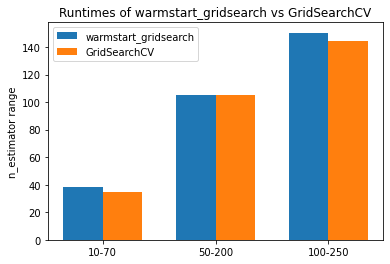

In [37]:


fig, ax = plt.subplots()
N = 3
ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, warm_runtimes, width)

p2 = ax.bar(ind + width, sklearn_runtimes, width)

ax.set_title("Runtimes of warmstart_gridsearch vs GridSearchCV")
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(("10-70", "50-200", "100-250"))

ax.legend((p1[0], p2[0]), ('warmstart_gridsearch', 'GridSearchCV'))
#ax.yaxis.set_units(seconds)
ax.autoscale_view()
ax.set_ylabel("Runtime (s)")
ax.set_ylabel("n_estimator range")
plt.show()
